In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch 
from argparse import Namespace
from tqdm import tqdm
import pickle 
import seaborn as sns
sns.set_theme() # set default theme for figures 

# Add the path to the directory containing the sybil module
sys.path.append('/workspace/home/tengyuezhang/sybil_cect/code/Sybil/')
from sybil.utils.metrics import concordance_index, get_survival_metrics
from sybil import Sybil, Serie

In [6]:
# =========== set the following parameters ===========
# file containing the risk scores of the cases and outcomes 
RISK_SCORE_FILE = '/workspace/home/tengyuezhang/sybil_cect/results/ucla_cect/ucla_cect_98_risk_scores.csv'
# file containing bootstrap data (pickle)
BOOTSTRAP_DATA_FILE = '/workspace/home/tengyuezhang/sybil_cect/results/ucla_cect/bootstrap_results.pkl'
# device to run the model on 
DEVICE = '1'
# number of bootstrap iterations to calculate metrics 
N_BOOTSTRAP = 1000
# maximum number of years of follow-up 
MAX_FOLLOWUP = 6
# =========== end of parameters ===========

In [26]:
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE

# load the Sybil model 
model = Sybil("sybil_ensemble")

# load the risk scores  
df = pd.read_csv(RISK_SCORE_FILE)
df['event'] = df['event_1'] # 'event_1' for first-year outcome 

/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
selected_columns = ['pred_risk_year_0', 'pred_risk_year_1', 'pred_risk_year_2', 
                    'pred_risk_year_3', 'pred_risk_year_4', 'pred_risk_year_5']
pred_risk_scores = df[selected_columns].values.tolist()

event_times = [0] * len(df)
# event_observed = np.array(df['event'])[:,None].tolist()
event_observed = np.array(df['event']).tolist()

In [55]:
np.isnan(pred_risk_scores)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, Fa

In [47]:
len(event_observed)

98

In [48]:
num_diagnosis = sum(np.array(df['event_1']))
pos_prop = num_diagnosis/len(np.array(df['event_1']))
print(num_diagnosis)
print(pos_prop)

40
0.40816326530612246


In [49]:
num_diagnosis_all_yr = sum(np.array(df['lung_cancer']))
pos_prop_all_yr = num_diagnosis_all_yr/len(np.array(df['lung_cancer']))
print(num_diagnosis_all_yr)
print(pos_prop_all_yr)

44.0
0.4489795918367347


In [50]:
input_dict = {
    "probs": torch.tensor(pred_risk_scores), 
    "censors": torch.tensor(event_times), 
    "golds": torch.tensor(event_observed)
}

args = Namespace(
    max_followup=1, censoring_distribution=model._censoring_dist
)

out = get_survival_metrics(input_dict, args)
print(out) ## NOTE: in the eval output, the index for year number starts at 1 instead of 0 

/workspace/home/tengyuezhang/sybil_cect/code/Sybil/sybil/utils/metrics.py:169: UserWarning: Failed to calculate AUC because Input contains NaN, infinity or a value too large for dtype('float32').
  warnings.warn("Failed to calculate AUC because {}".format(e))


UnboundLocalError: local variable 'year_roc_curve' referenced before assignment

In [61]:
# Parameters
n_bootstraps = 5000 
random_seed = 42 
np.random.seed(random_seed)

# BOOTSTRAP_DATA_FILE

In [30]:
max_followup = 1

auroc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 
auprc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 
args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

# to store bootstrapped metrics 
bootstrapped_auroc = {f'year_{i+1}': [] for i in range(max_followup)}
bootstrapped_auprc = {f'year_{i+1}': [] for i in range(max_followup)}

# for i in range(n_bootstraps): 
for i in tqdm(range(n_bootstraps), desc="Bootstrapping", ncols=100):
    # resample data with replacement 
    bootstrap_indices = resample(range(len(df)), replace=True, n_samples=len(df))
    df_bootstrap = df.iloc[bootstrap_indices]
    pred_risk_scores_bootstrap = df_bootstrap[selected_columns].values.tolist()
    event_times_bootstrap = [0] * len(df_bootstrap)
    event_observed_bootstrap = df_bootstrap['event'].tolist() 
    
    if len(set(event_observed_bootstrap)) == 1:
        warnings.warn(f"Skipping bootstrap iteration {i} due to single class in labels.")
        continue
        
    input_dict_bootstrap = {
        "probs": torch.tensor(pred_risk_scores_bootstrap), 
        "censors": torch.tensor(event_times_bootstrap), 
        "golds": torch.tensor(event_observed_bootstrap)
    }
    
    bootstrap_metrics = get_survival_metrics(input_dict_bootstrap, args)
    
    # print(bootstrap_metrics) 
    
    for year in range(1, max_followup+1): 
        bootstrapped_auroc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_auc'])
        bootstrapped_auprc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_prauc'])
    

Bootstrapping: 100%|███████████████████████████████████████████| 5000/5000 [00:20<00:00, 244.94it/s]


In [31]:
import pickle 
bootstrap_results = {
    'bootstrapped_auroc': bootstrapped_auroc,  # AUROC
    'bootstrapped_auprc': bootstrapped_auprc, 
}
with open(BOOTSTRAP_DATA_FILE, 'wb') as f:
    pickle.dump(bootstrap_results, f)

In [62]:
# Load the dictionary from the pickle file
with open(BOOTSTRAP_DATA_FILE, 'rb') as f:
    loaded_results = pickle.load(f)

# Accessing the loaded data
bootstrapped_auroc = loaded_results['bootstrapped_auroc']
bootstrapped_auprc = loaded_results['bootstrapped_auprc']

In [63]:
# 1) calculate mean AUROC and CIs for each year
auroc_results = {}
for year in range(1, max_followup+1):
    auroc_scores = bootstrapped_auroc[f'year_{year}']
    mean_auroc = np.mean(auroc_scores)
    lower_bound = np.percentile(auroc_scores, 2.5)
    upper_bound = np.percentile(auroc_scores, 97.5)
    auroc_results[f'year_{year}'] = {
        'mean_auroc': mean_auroc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUROC ========')
for year in range(1, max_followup+1): 
    year_auroc = auroc_results[f'year_{year}']['mean_auroc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auroc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')
    
# 2) calculate mean AUPRC and CIs for each year 
auprc_results = {}
for year in range(1, max_followup+1):
    auprc_scores = bootstrapped_auprc[f'year_{year}']
    mean_auprc = np.mean(auprc_scores)
    lower_bound = np.percentile(auprc_scores, 2.5)
    upper_bound = np.percentile(auprc_scores, 97.5)
    auprc_results[f'year_{year}'] = {
        'mean_auprc': mean_auprc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUPRC ========')
for year in range(1, max_followup+1): 
    year_auprc = auprc_results[f'year_{year}']['mean_auprc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auprc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')



======== AUROC ========
Year 1 mean AUROC=0.4974 (CI: [0.21-0.77])
======== AUPRC ========
Year 1 mean AUROC=0.6524 (CI: [0.36-0.89])


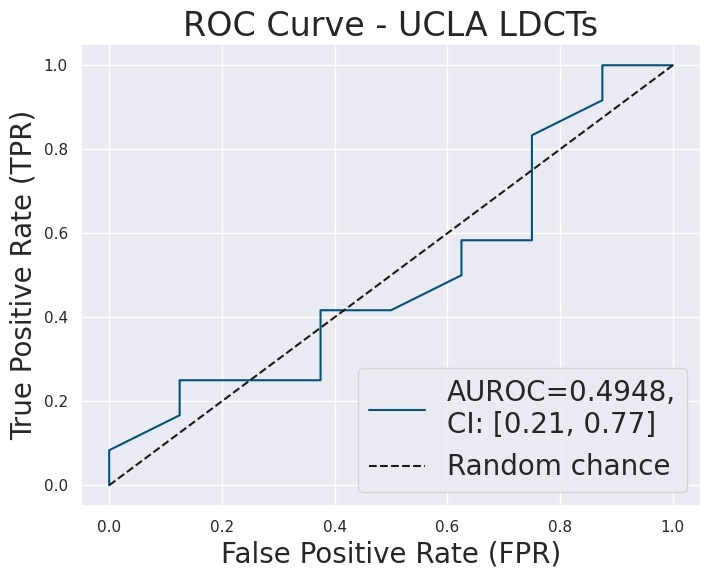

In [65]:
# Extract the C-index
# c_index = aapm_out['c_index']
colors = ['#045275', '#089099', '#7CCBA2', '#FABF7B', '#E05C5C', '#AB1866']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    year_auroc = out[f'{year}_year_auc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(fpr, tpr, 
            label=f'AUROC={year_auroc:.4f},\nCI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=20)
plt.ylabel('True Positive Rate (TPR)', fontsize=20)
plt.title(f'ROC Curve - UCLA LDCTs', fontsize=24)
plt.legend(loc='lower right', fontsize=20)
# plt.savefig('/workspace/home/kkulkarni/Sybil/Results/Lungx/Lungx_roc_bootstrapped.png')
# Show plot
plt.show()

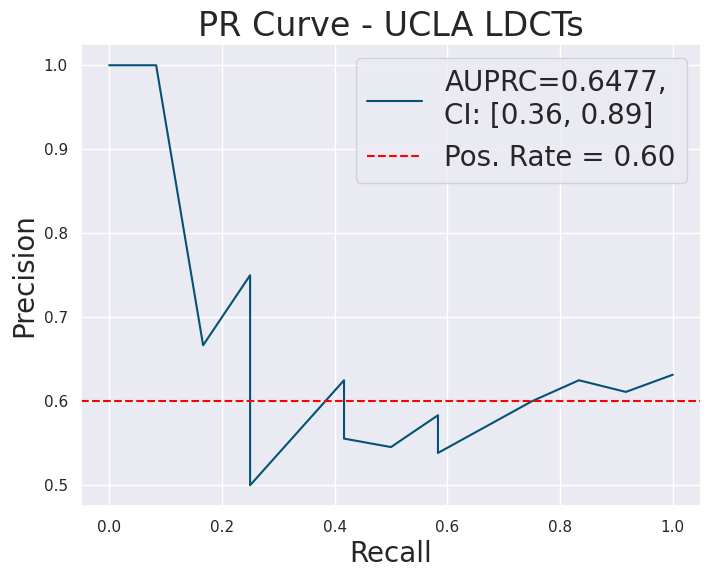

In [67]:
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    pr_curve_data = out[f'{year}_year_pr_curve']
    recall = pr_curve_data['recall']
    precision = pr_curve_data['precision']
    year_auprc = out[f'{year}_year_prauc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(recall, precision, 
            label=f'AUPRC={year_auprc:.4f},\nCI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Plot horizontal line at 0.1515 to indicate the proportion of positive samples
plt.axhline(y=pos_prop, color='red', linestyle='--', 
            label=f'Pos. Rate = {pos_prop:.2f}')


# Set plot labels and title
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title(f'PR Curve - UCLA LDCTs', fontsize=24)
plt.legend(loc='upper right', fontsize=20)
# plt.savefig('/workspace/home/kkulkarni/Sybil/Results/Lungx/Lungx_prc_bootstrapped.png')
# Show plot
plt.show()

In [1]:
RISK_CUTOFF=0.0121
IN_ATTN_MAPS_PATH = '/workspace/home/tengyuezhang/sybil_cect/visualizations/ucla_ldct_20_attention_maps'
OUT_SORTED_PATH = '/workspace/home/tengyuezhang/sybil_cect/visualizations/ucla_ldct_sorted_20_attention_maps'

In [6]:
# TP: event == 1 and pred_risk_year_1 >= RISK_CUTOFF
tp_df = df[(df['event'] == 1) & (df['pred_risk_year_1'] >= RISK_CUTOFF)]

# FP: event == 0 and pred_risk_year_1 >= RISK_CUTOFF
fp_df = df[(df['event'] == 0) & (df['pred_risk_year_1'] >= RISK_CUTOFF)]

# FN: event == 1 and pred_risk_year_1 < RISK_CUTOFF
fn_df = df[(df['event'] == 1) & (df['pred_risk_year_1'] < RISK_CUTOFF)]

# TN: event == 0 and pred_risk_year_1 < RISK_CUTOFF
tn_df = df[(df['event'] == 0) & (df['pred_risk_year_1'] < RISK_CUTOFF)]

In [7]:
print("True Positives (TP):", tp_df.shape[0])
print("False Positives (FP):", fp_df.shape[0])
print("False Negatives (FN):", fn_df.shape[0])
print("True Negatives (TN):", tn_df.shape[0])

True Positives (TP): 12
False Positives (FP): 7
False Negatives (FN): 0
True Negatives (TN): 1


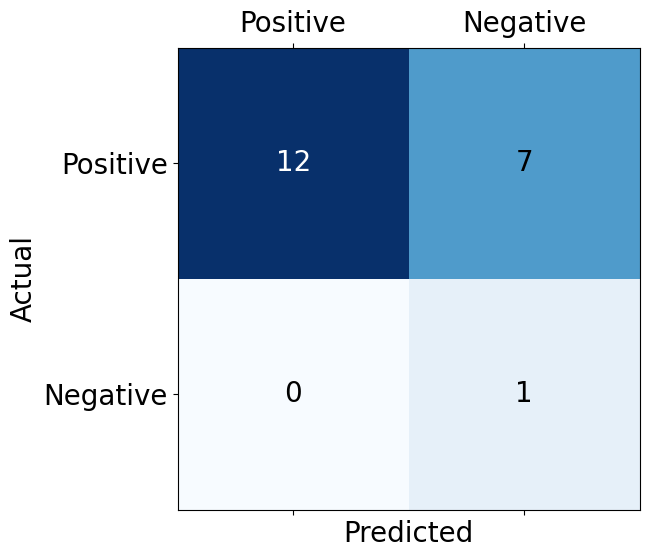

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

TP = tp_df.shape[0]
FP = fp_df.shape[0]
FN = fn_df.shape[0]
TN = tn_df.shape[0]

confusion_matrix = np.array([[TP, FP],
                             [FN, TN]])
categories = ['Positive', 'Negative']

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confusion_matrix, cmap='Blues')
# plt.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    color = cax.get_cmap()(cax.norm(confusion_matrix[i, j]))  # Get the RGBA color of the cell
    luminance = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]  # Calculate luminance
    text_color = 'white' if luminance < 0.5 else 'black'  # Choose text color based on luminance
    ax.text(j, i, f'{val}', ha='center', va='center', color=text_color, fontsize=20)

ax.set_xticks([0, 1])
ax.set_xticklabels(categories, fontsize=20)
ax.set_yticks([0, 1])
ax.set_yticklabels(categories, fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
ax.set_ylabel('Actual', fontsize=20)

plt.show()


In [8]:
# Create the main folder
os.makedirs(OUT_SORTED_PATH, exist_ok=True)

# Create subfolders for FP, TP, TN, FN
subfolders = ['FP', 'TP', 'TN', 'FN']
for folder in subfolders:
    os.makedirs(os.path.join(OUT_SORTED_PATH, folder), exist_ok=True)

In [11]:
import shutil
def copy_folders_from_df(df,label, base_path, main_folder):
    for index, row in df.iterrows():
        pid = row['pid']  # Adjust based on your DataFrame structure

        # Construct the source folder path
        source_folder = os.path.join(base_path, pid)  # Adjust path as needed

        # Determine the destination folder
        if label in ['FP', 'TP', 'TN', 'FN']:
            dest_folder = os.path.join(main_folder, label, pid)

            # Check if the destination folder already exists
            if not os.path.exists(dest_folder):
                # Check if the source folder exists
                if os.path.exists(source_folder):
                    # Copy the folder to the destination
                    shutil.copytree(source_folder, dest_folder)
                else:
                    print(f"Source folder {source_folder} does not exist.")
            else:
                print(f"Destination folder {dest_folder} already exists. Skipping copy.")

In [12]:
copy_folders_from_df(fp_df, 'FP', IN_ATTN_MAPS_PATH, OUT_SORTED_PATH )
# add FPs, etc. below 